### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [3]:
import numpy as np
import pickle
import os
import cv2


X_CORNERS = 9
Y_CORNERS = 6
BASE_DIR = os.path.abspath('.')


CALIBRATION_IMAGES_DIR = 'camera_cal'


def run_calibration():
    objp = np.zeros((X_CORNERS * Y_CORNERS, 3), np.float32)
    objp[:, :2] = np.mgrid[0:X_CORNERS, 0:Y_CORNERS].T.reshape(-1, 2)
    # Arrays to store object points and image points from all the images.
    obj_points = []  # 3d points in real world space
    img_points = []  # 2d points in image plane.

    for image_dir in os.listdir(
            os.path.join(BASE_DIR, CALIBRATION_IMAGES_DIR)
    ):
        if not image_dir.endswith('jpg'):
            continue
        img = cv2.imread(
            os.path.join(BASE_DIR, CALIBRATION_IMAGES_DIR, image_dir)
        )
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        found, corners = cv2.findChessboardCorners(gray, (X_CORNERS, Y_CORNERS))

        if found:
            obj_points.append(objp)
            img_points.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        obj_points, img_points, gray.shape[::-1], None, None
    )

    pickle.dump(
        {'mtx': mtx, 'dist': dist},
        open(os.path.join(CALIBRATION_IMAGES_DIR, 'mtx_dist_pickle.p'), 'wb')
    )

In [4]:
# run and save calibration

run_calibration()

### Apply a distortion correction to raw images.

In [5]:
import glob
import pickle

SAVE_DIR = 'test_images/corrected'

MTX_DICT = pickle.load(open('camera_cal/mtx_dist_pickle.p', 'rb'))


def undistort(img):
    return cv2.undistort(img, MTX_DICT['mtx'], MTX_DICT['dist'], None, MTX_DICT['mtx'])


def run_undistort():
    for image_url in glob.glob('test_images/*.jpg'):
        img = cv2.imread(image_url)
        cv2.imwrite(
            image_url.replace(
                os.path.split(image_url)[0], SAVE_DIR
            ),
            undistort(img)
        )

In [6]:
run_undistort()

In [9]:
# helper function to show plt grid
import matplotlib.pyplot as plt

# opecv by default reads all images as BGR, to display we need RGB
def _convert_to_RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def _gray_to_RGB(gray):
    img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    return img

def _binary_to_RGB(binary):
    return np.dstack((binary, binary, binary)) * 255

# solution from https://stackoverflow.com/a/47334314
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        if column == no_of_columns + 1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')
        if len(list_of_titles) > i:
            plt.title(list_of_titles[i])


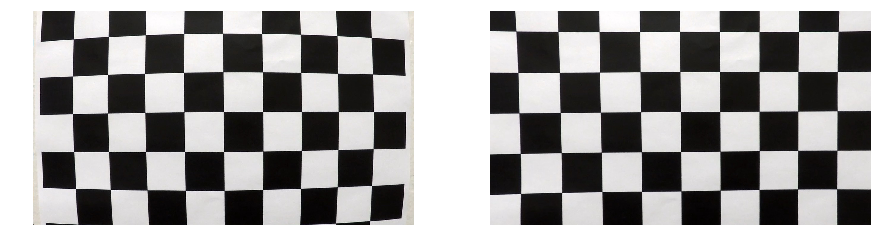

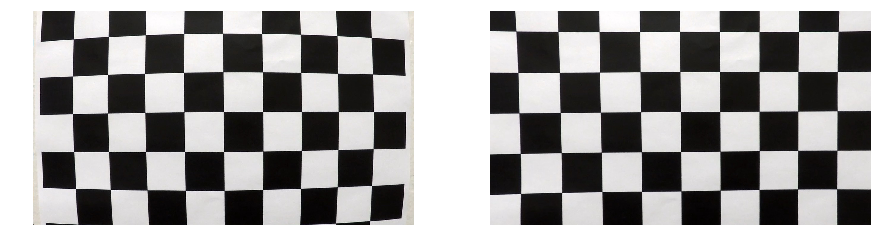

In [10]:
grid_display(
    [
        _convert_to_RGB(cv2.imread('camera_cal/calibration1.jpg')),
        _convert_to_RGB(undistort(cv2.imread('camera_cal/calibration1.jpg'))),
        _convert_to_RGB(cv2.imread('camera_cal/calibration1.jpg')),
        _convert_to_RGB(undistort(cv2.imread('camera_cal/calibration1.jpg'))),
    ],
    figsize=(15, 15)
)


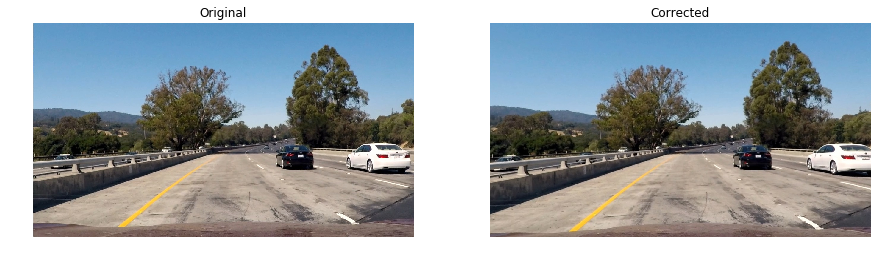

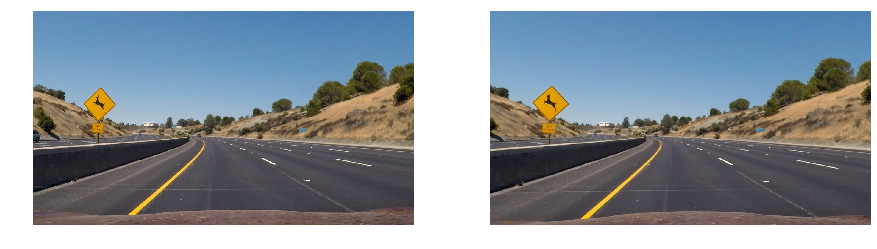

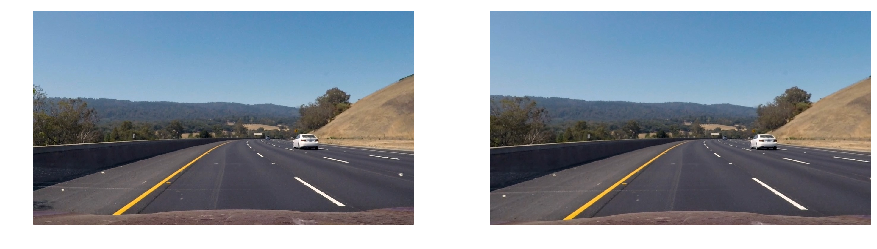

In [12]:

grid_display(
    [
        _convert_to_RGB(cv2.imread('test_images/test1.jpg')),
        _convert_to_RGB(cv2.imread('test_images/corrected/test1.jpg')),
        _convert_to_RGB(cv2.imread('test_images/test2.jpg')),
        _convert_to_RGB(cv2.imread('test_images/corrected/test2.jpg')),
        _convert_to_RGB(cv2.imread('test_images/test3.jpg')),
        _convert_to_RGB(cv2.imread('test_images/corrected/test3.jpg'))
    ],
    list_of_titles=[
      'Original', 'Corrected'  
    ],
    figsize=(15, 15)
)


### Use color transforms, gradients, etc., to create a thresholded binary image.


In [13]:
import cv2

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255, kernel=3):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, kernel)

    abs_sobel = np.absolute(sobel)

    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    sxbinary = np.zeros_like(scaled_sobel)

    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), convert_to_gray=True):
    if convert_to_gray:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2), convert_to_gray=True):
    if convert_to_gray:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def thresh(gray, thresh=(0,255)):
    """
    Simple thresh
    :param gray: 
    :param thresh: 
    :return: 
    """
    binary = np.zeros_like(gray)
    binary[(gray >= thresh[0]) & (gray <= thresh[1])] = 1
    return binary


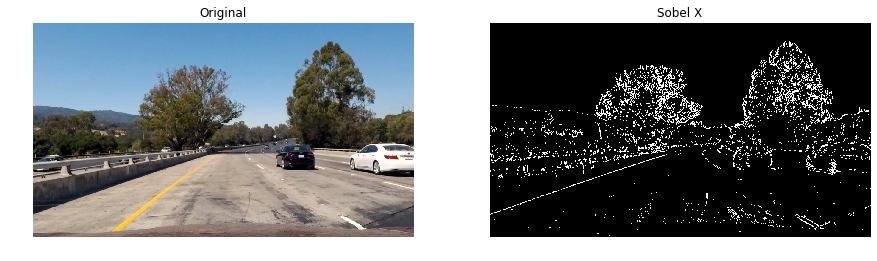

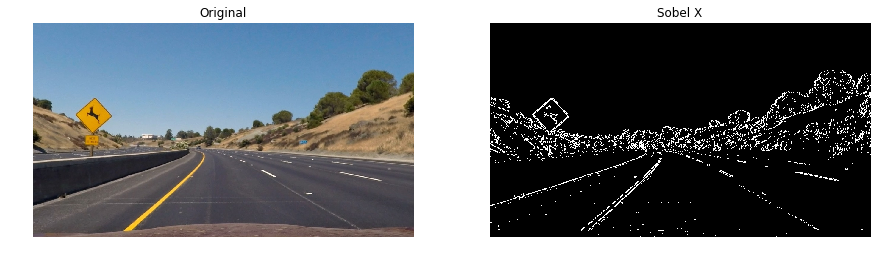

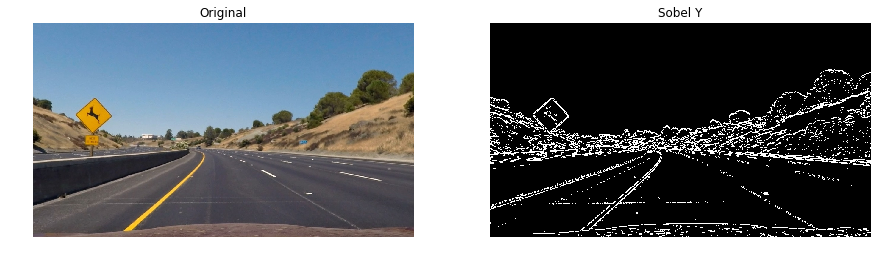

In [14]:
# abs_sobel_thresh test 


grid_display(
    [
        _convert_to_RGB(cv2.imread('test_images/corrected/test1.jpg')),
        _binary_to_RGB(
            abs_sobel_thresh(_convert_to_RGB(cv2.imread('test_images/corrected/test1.jpg')), 'x', 20, 100),
        ),
        _convert_to_RGB(cv2.imread('test_images/corrected/test2.jpg')),
        _binary_to_RGB(
            abs_sobel_thresh(
                _convert_to_RGB(cv2.imread('test_images/corrected/test2.jpg')),
                'x', 20, 100),
        ),
        _convert_to_RGB(cv2.imread('test_images/corrected/test2.jpg')),
        _binary_to_RGB(
            abs_sobel_thresh(
                _convert_to_RGB(cv2.imread('test_images/corrected/test2.jpg')),
                'y', 20, 100)
        )

    ],
    list_of_titles=[
        "Original", "Sobel X",
        "Original", "Sobel X",
        "Original", "Sobel Y",
    ],
    figsize=(15, 15)
)



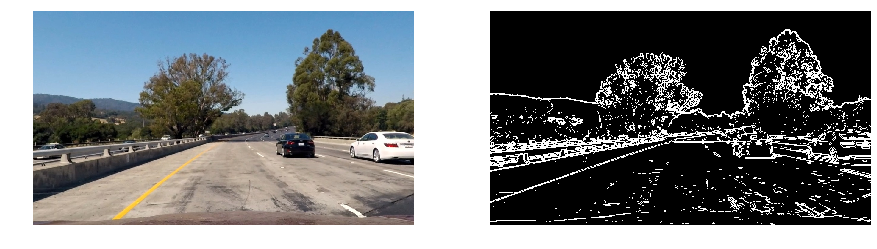

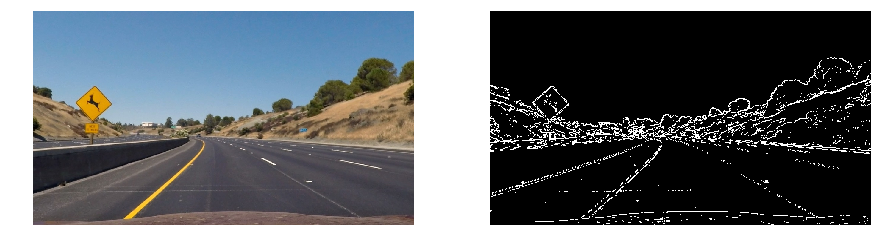

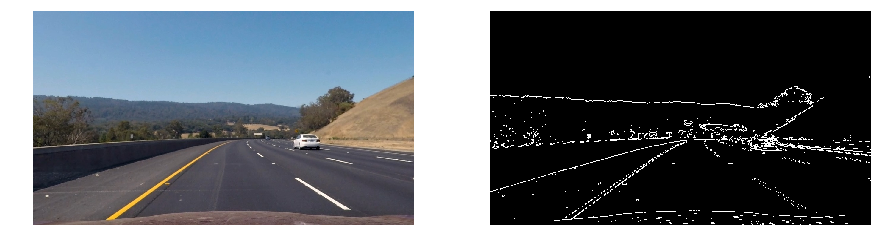

In [15]:
# mag_thresh demo

grid_display(
    [
        _convert_to_RGB(cv2.imread('test_images/corrected/test1.jpg')),
        _binary_to_RGB(
            mag_thresh(_convert_to_RGB(cv2.imread('test_images/corrected/test1.jpg')),
                       sobel_kernel=9, mag_thresh=(30, 150)),
        ),
        _convert_to_RGB(cv2.imread('test_images/corrected/test2.jpg')),
        _binary_to_RGB(
            mag_thresh(
                _convert_to_RGB(cv2.imread('test_images/corrected/test2.jpg')),
                mag_thresh=(30, 100)),
        ),
        _convert_to_RGB(cv2.imread('test_images/corrected/test3.jpg')),
        _binary_to_RGB(
            mag_thresh(
                _convert_to_RGB(cv2.imread('test_images/corrected/test3.jpg')),
                mag_thresh=(30, 100))
        )

    ],
    figsize=(15, 15)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


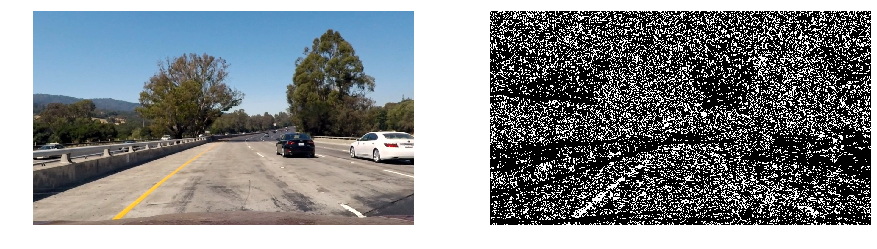

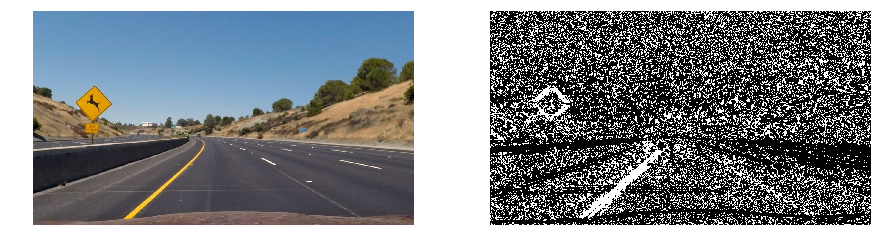

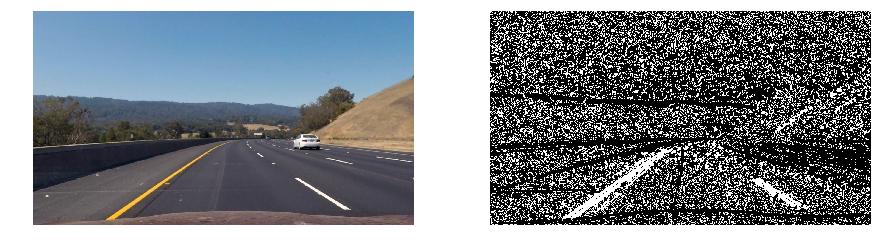

In [16]:
# test dir_threshold

dir_sobel_kernel = 25
dir_thresh = (0.6, 1.1)

grid_display(
    [
        _convert_to_RGB(cv2.imread('test_images/corrected/test1.jpg')),
        _binary_to_RGB(
            dir_threshold(_convert_to_RGB(cv2.imread('test_images/corrected/test1.jpg')),
                          dir_sobel_kernel, dir_thresh
                          )),
        _convert_to_RGB(cv2.imread('test_images/corrected/test2.jpg')),
        _binary_to_RGB(
            dir_threshold(
                _convert_to_RGB(cv2.imread('test_images/corrected/test2.jpg')),
                dir_sobel_kernel, dir_thresh
            )),
        _convert_to_RGB(cv2.imread('test_images/corrected/test3.jpg')),
        _binary_to_RGB(
            dir_threshold(
                _convert_to_RGB(cv2.imread('test_images/corrected/test3.jpg')),
                dir_sobel_kernel, dir_thresh
            ))

    ],
    figsize=(15, 15)
)


In [24]:
import glob
import cv2


def process_image_v1(img, threshold=(0, 255)):
    # convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]

    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 1, ksize=3)
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    thresh_min = 40
    thresh_max = 120
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary


def process_image_v2(img):
    sobel_dir = dir_threshold(img, 25, (.6, 1.1))
    sobel_mag = mag_thresh(img, 9, (30, 150))

    combined = np.zeros_like(sobel_mag)
    combined[((sobel_dir == 1) & (sobel_mag == 1))] = 1
    return combined


def process_images():
    for image_path in glob.glob('test_images/corrected/*.jpg'):
        img = cv2.imread(image_path)

        img_processed = process_image_v1(img)

        cv2.imwrite(
            image_path.replace(
                os.path.split(image_path)[0], 'test_images/threshold1'
            ),
            np.dstack((img_processed, img_processed, img_processed)) * 255
        )


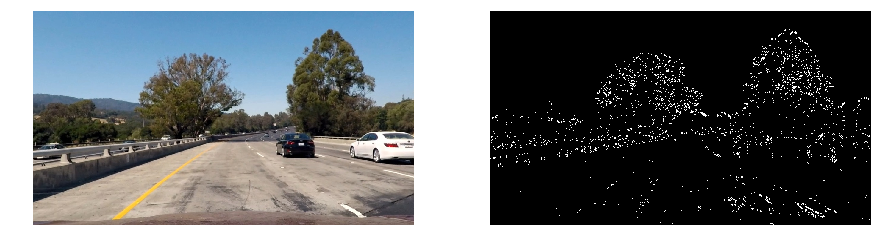

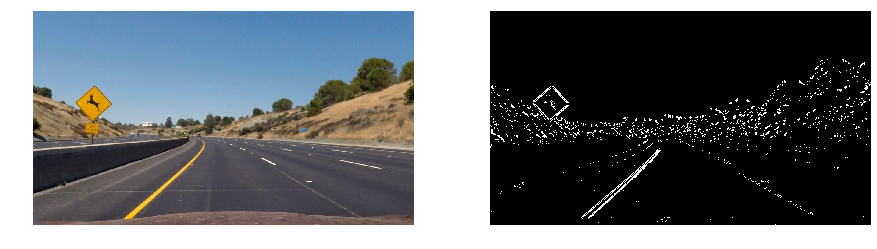

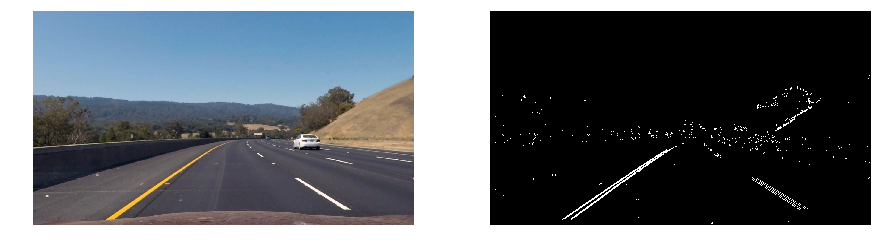

In [25]:
grid_display(
    [
        _convert_to_RGB(cv2.imread('test_images/corrected/test1.jpg')),
        _binary_to_RGB(process_image_v2(
            _convert_to_RGB(cv2.imread('test_images/corrected/test1.jpg')),
        )),
        
        _convert_to_RGB(cv2.imread('test_images/corrected/test2.jpg')),
        _binary_to_RGB(process_image_v2(
            _convert_to_RGB(cv2.imread('test_images/corrected/test2.jpg')),
        )),
        _convert_to_RGB(cv2.imread('test_images/corrected/test3.jpg')),
        _binary_to_RGB(process_image_v2(
            _convert_to_RGB(cv2.imread('test_images/corrected/test3.jpg')),
        ))

    ],
    figsize=(15, 15)
)

### Test different color channels

In [26]:

def convert_to_HSV(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)


def convert_to_HLS(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)


def convert_to_LAB(img):
        return cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

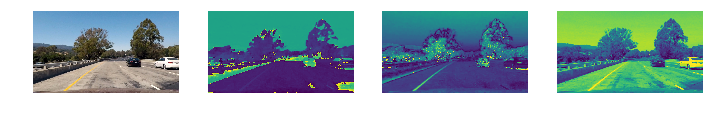

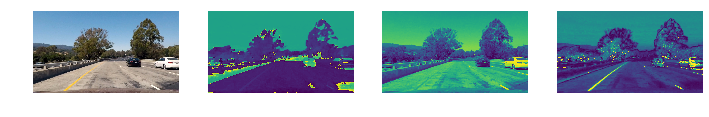

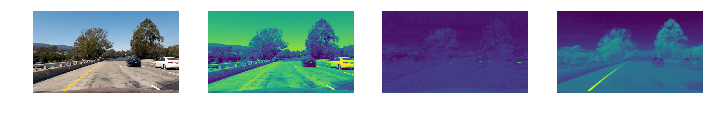

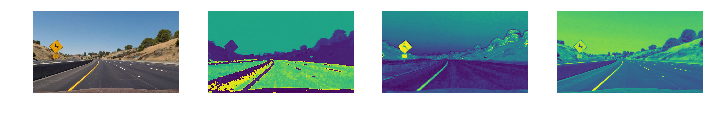

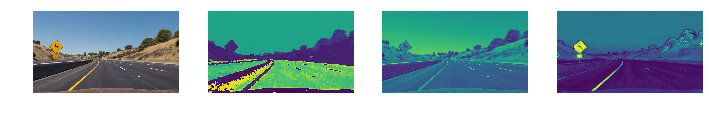

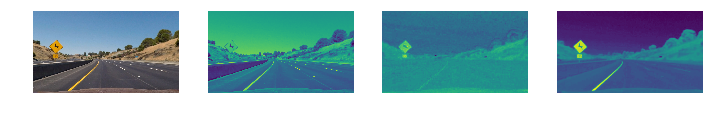

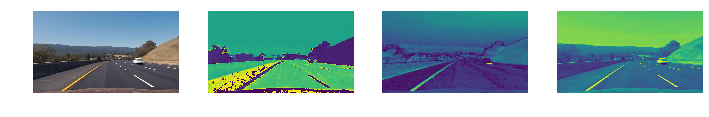

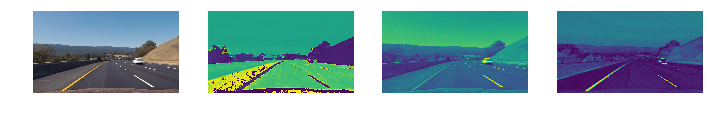

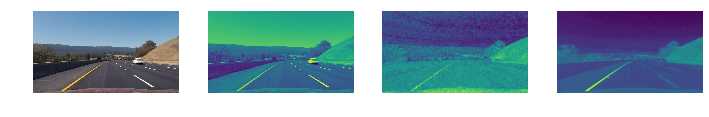

In [27]:
def add_all_version_for_image(img_name):
    return [
        _convert_to_RGB(cv2.imread('test_images/corrected/{}'.format(img_name))),
        convert_to_HSV(
            _convert_to_RGB(cv2.imread('test_images/corrected/{}'.format(img_name)))
        )[:, :, 0],
        convert_to_HSV(
            _convert_to_RGB(cv2.imread('test_images/corrected/{}'.format(img_name)))
        )[:, :, 1],
        convert_to_HSV(
            _convert_to_RGB(cv2.imread('test_images/corrected/{}'.format(img_name)))
        )[:, :, 2],

        _convert_to_RGB(cv2.imread('test_images/corrected/{}'.format(img_name))),
        convert_to_HLS(
            _convert_to_RGB(cv2.imread('test_images/corrected/{}'.format(img_name)))
        )[:, :, 0],
        convert_to_HLS(
            _convert_to_RGB(cv2.imread('test_images/corrected/{}'.format(img_name)))
        )[:, :, 1],
        convert_to_HLS(
            _convert_to_RGB(cv2.imread('test_images/corrected/{}'.format(img_name)))
        )[:, :, 2],

        _convert_to_RGB(cv2.imread('test_images/corrected/{}'.format(img_name))),
        convert_to_LAB(
            _convert_to_RGB(cv2.imread('test_images/corrected/{}'.format(img_name)))
        )[:, :, 0],
        convert_to_LAB(
            _convert_to_RGB(cv2.imread('test_images/corrected/{}'.format(img_name)))
        )[:, :, 1],
        convert_to_LAB(
            _convert_to_RGB(cv2.imread('test_images/corrected/{}'.format(img_name)))
        )[:, :, 2],
    ]


grid_display(
    (
        add_all_version_for_image('test1.jpg') +
        add_all_version_for_image('test2.jpg') +
        add_all_version_for_image('test3.jpg') 
    ),
    no_of_columns=4,
    figsize=(12, 12)
)


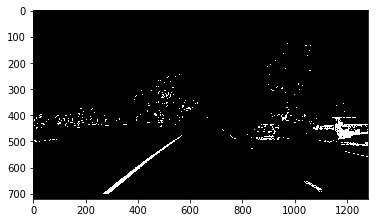

In [28]:
# check thrash only with S channel from HLS

saturation = convert_to_HLS(_convert_to_RGB(cv2.imread('test_images/corrected/test1.jpg')))[:, :, 2]

plt.imshow(_binary_to_RGB(
    thresh(saturation, (170, 255)))
)

In [39]:
def image_pipeline_final(img):
    image = undistort(img)
    
    sobel_x = abs_sobel_thresh(image, 'x', 30, 250, 7)
    sobel_y = abs_sobel_thresh(image, 'y', 15, 250, 7)
    
    saturation = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[..., 2]
    
    saturation_b = thresh(saturation, (170, 250))
    
    combined_binary = np.zeros_like(sobel_x)
    combined_binary[(saturation_b == 1) | ((sobel_x == 1) & (sobel_y == 1))] = 1

    return combined_binary

In [40]:
# check how threshold movie looks like

from moviepy.editor import VideoFileClip

project_clip = VideoFileClip('project_video.mp4')
output_clip = project_clip.fl_image(image_pipeline_final)
output_clip.write_videofile('project_video_threshold.mp4', audio=False)

[MoviePy] >>>> Building video project_video_threshold.mp4
[MoviePy] Writing video project_video_threshold.mp4


100%|█████████▉| 1260/1261 [01:09<00:00, 19.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_threshold.mp4 



In [31]:
width = 1280
height = 720

source_vertices = np.float32(
        [
            [width * 0.44, height * 0.64],
            [width * 0.59, height * 0.64],
            [width * 0.9, height * 0.95],
            [width * 0.17, height * 0.95]
        ]
    )
destination_vertices = np.float32([
        [width * 0.1, 0],
        [width * 0.9, 0],
        [width * 0.9, height],
        [width * 0.1, height]
    ])

transform = cv2.getPerspectiveTransform(source_vertices, destination_vertices)
transform_back = cv2.getPerspectiveTransform(destination_vertices, source_vertices)


ym_per_pix = 30/720  # meters per pixel in y dimension
xm_per_pix = 3.7/700  # meters per pixel in x dimension

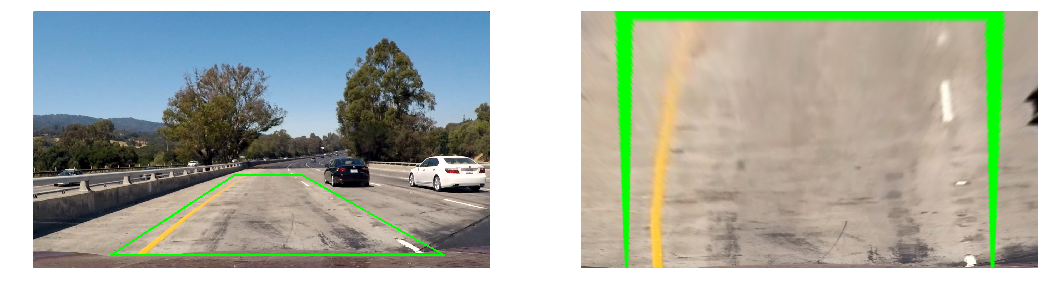

In [32]:
# test transformation

img_1 = _convert_to_RGB(
    cv2.imread('test_images/test1.jpg')
)

cv2.polylines(
    img_1, np.int32([source_vertices]), True, (0, 255, 0), 3
)

newwarp = cv2.warpPerspective(img_1, transform, (width, height)) 

grid_display([
    img_1, newwarp
], figsize=(18, 18))


In [33]:
def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0] * 0.75):, :], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)

    # getting leftx_base and right_base searching for max position
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 14
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 40

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()

    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows

    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height

        # this is for left frame
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin

        # this is for right frame
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = (
                (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)
        ).nonzero()[0]
        
        good_right_inds = (
                (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)
        ).nonzero()[0]
        

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # getting avarage x-pixel for non-zero values

        if len(good_left_inds) > minpix:
            leftx_current = np.int(
                np.mean(nonzerox[good_left_inds])
            )

        if len(good_right_inds) > minpix:
            rightx_current = np.int(
                np.mean(nonzerox[good_right_inds])
            )

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_fit_m = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_m = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    return left_fit, right_fit, left_fit_m, right_fit_m


In [34]:
def search_around_poly(binary_warped, left_fit, right_fit):
    margin = 100

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_fit_m = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_m = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    return left_fit, right_fit, left_fit_m, right_fit_m

In [35]:

def draw_line(img, M, left_fit, right_fit):
    img_width = img.shape[1]
    img_height = img.shape[0]
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    ploty = np.linspace(0, img_height, num=10)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    newwarp = cv2.warpPerspective(color_warp, M, (img_width, img_height))
    result = cv2.addWeighted(img, 1, newwarp, 0.4, 0)
    
    return result

In [36]:


def calculate_radius(y_eval, left_fit_m, right_fit_m):    
    left_radius = ((1 + (2*left_fit_m[0]*y_eval + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_radius = ((1 + (2*right_fit_m[0]*y_eval + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
    
    return left_radius, right_radius


def calculate_deviation(y_eval_pix, width_pix, left_fit_m, right_fit_m):
    x1 = left_fit_m[0]*(y_eval_pix * ym_per_pix)**2 + left_fit_m[1]*30 + left_fit_m[2]
    x2 = right_fit_m[0]*(y_eval_pix * ym_per_pix)**2 + right_fit_m[1]*30 + right_fit_m[2]
    return (x2 + x1) * 0.5 - (width_pix * xm_per_pix) * 0.5


In [37]:
class ProcessWrapper:
    def __init__(self):
        self.data = None

    @property
    def left_fit(self):
        if self.data:
            return self.data[0]

    @property
    def right_fit(self):
        if self.data:
            return self.data[1]
        
    @property
    def left_fit_m(self):
        if self.data:
            return self.data[2]
        
    @property
    def right_fit_m(self):
        if self.data:
            return self.data[3]

    def add_measurement_info(self, img):
        font_args = [
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2
        ]
        radius_left, radius_right = calculate_radius(height, self.left_fit_m, self.right_fit_m)
        deviation = calculate_deviation(height, width, self.left_fit_m, self.right_fit_m)

        cv2.putText(
            img, 'radius: left {:.3f} right {:.3f}'.format(radius_left, radius_right), (20, 40),
            *font_args
        )

        direction = 'left' if deviation < 0 else 'right'
        cv2.putText(
            img, 'distance from center: {:.3f}m {}'.format(np.absolute(deviation), direction),
            (20, 80), *font_args
        )

    def process(self, img):
        undistort_img = undistort(img)

        combined = image_pipeline_final(undistort_img)

        combined_warp = cv2.warpPerspective(
            combined, transform, (width, height), flags=cv2.INTER_LINEAR
        )

        if self.data is None:
            self.data = find_lane_pixels(combined_warp)
        else:
            self.data = search_around_poly(combined_warp, self.left_fit, self.right_fit)

        lines_img = draw_line(
            undistort_img,
            transform_back,
            self.left_fit,
            self.right_fit
        )
        
        self.add_measurement_info(lines_img)
        
        return lines_img


In [38]:
from moviepy.editor import VideoFileClip

p = ProcessWrapper()
project_clip = VideoFileClip('project_video.mp4')
output_clip = project_clip.fl_image(p.process)
output_clip.write_videofile('project_video_out.mp4', audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [02:21<00:00,  9.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

